# SPamCo with Ensembles

In [1]:
#Math packages
import numpy as np

#Data packages
import pandas as pd
from pandas_profiling import ProfileReport

#Spamco
from spamco import SPamCo, Validation

#Data packages
from sklearn.datasets import make_moons, make_classification, make_circles, make_blobs, make_gaussian_quantiles
from sklearn.datasets import load_breast_cancer, load_digits, load_iris
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

#Classifier packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

#Validation packages
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

#Visualization packages
import plotly.express as px

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
from matplotlib.ticker import MaxNLocator
%matplotlib inline

import baycomp

#General utility packages
from itertools import cycle, islice
import warnings

warnings.filterwarnings("ignore")
matplotlib.rcParams.update({'font.size': 20})

# Diabetes Health Indicators Dataset

In [2]:
df = pd.read_csv('Data/diabetes.csv')

In [3]:
y =df.values[:,0]
X =df.drop(['Diabetes_012','AnyHealthcare'], axis = 1).values

In [4]:
df.describe()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.296921,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.698160,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,2.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


In [5]:
int(X.shape[0]/20)

12684

In [6]:
np.random.seed(1)
seeds = np.random.randint(low = 1, high = 10000, size = (10, 5))

In [7]:
label_pct = np.arange(1, 21)/2000

In [8]:
label_pct = np.concatenate((label_pct,np.array([0.1, 0.5, .99])), axis=0 )

In [4]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
clf = RandomForestClassifier()
gridcv = GridSearchCV(clf, param_grid)
gridcv.fit(X, y)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [5]:
gridcv.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 500}

## AdaBoost

In [8]:
adaboost_base_metrics = []
adaboost_base_clfs = []

model =  {
    'classifier':AdaBoostClassifier(),
    'num_view':1,
    'gamma':0.3,
    'steps':5,
    'regularizer':'hard'
}
for i in label_pct:
    clfs, metrics = Validation.validation(
        model_params=model,
        train_data_x=X,
        train_data_y=y,
        percent_labeled=i,
        random_seed=seeds[0],
        iters=5
    )

    adaboost_base_metrics.append(metrics)
    adaboost_base_clfs.append(clfs)

adaboost_base_score = np.array(adaboost_base_metrics)

Validation Iteration: 0 Accuracy: 0.8176442762535477 Labels: 88
Validation Iteration: 0 Accuracy: 0.7260722169662567 Labels: 177
Validation Iteration: 0 Accuracy: 0.5650819930621255 Labels: 266
Validation Iteration: 0 Accuracy: 0.8122831914222642 Labels: 355
Validation Iteration: 0 Accuracy: 0.7139966361820667 Labels: 443
Validation Iteration: 0 Accuracy: 0.822190686429097 Labels: 532
Validation Iteration: 0 Accuracy: 0.8233864185850941 Labels: 621
Validation Iteration: 0 Accuracy: 0.8308630295385262 Labels: 710
Validation Iteration: 0 Accuracy: 0.8230842005676443 Labels: 799
Validation Iteration: 0 Accuracy: 0.8263428991905813 Labels: 887
Validation Iteration: 0 Accuracy: 0.8261063807421424 Labels: 976
Validation Iteration: 0 Accuracy: 0.825843582466099 Labels: 1065
Validation Iteration: 0 Accuracy: 0.8319010827288973 Labels: 1154
Validation Iteration: 0 Accuracy: 0.8335304320403658 Labels: 1243
Validation Iteration: 0 Accuracy: 0.8359744560075686 Labels: 1331
Validation Iteration: 0 

In [9]:
adaboost_multi_metrics = []
adaboost_multi_clfs = []
steps = 20
views = 2

model =  {
    'classifier':AdaBoostClassifier(),
    'num_view':views,
    'gamma':0.3,
    'steps':steps,
    'regularizer':'hard',
    'update_add_num': int(X.shape[0]/steps)
}

for i in label_pct:
    clfs, metrics = Validation.validation(
        model_params=model,
        train_data_x=X,
        train_data_y=y,
        percent_labeled=i,
        random_seed=seeds[0],
        spaco=True,
        iters=5,
        hsplit=True,
        hsplit_size=views
    )

    adaboost_multi_metrics.append(metrics)
    adaboost_multi_clfs.append(clfs)

adaboost_multi_score = np.array(adaboost_multi_metrics)

Validation Iteration: 0 Accuracy: 0.6123988226637234 Labels: 88
Validation Iteration: 0 Accuracy: 0.14490696941028067 Labels: 177
Validation Iteration: 0 Accuracy: 0.8399295700620204 Labels: 266
Validation Iteration: 0 Accuracy: 0.8424130137706297 Labels: 355
Validation Iteration: 0 Accuracy: 0.8424130137706297 Labels: 443
Validation Iteration: 0 Accuracy: 0.8424130137706297 Labels: 532
Validation Iteration: 0 Accuracy: 0.8424130137706297 Labels: 621
Validation Iteration: 0 Accuracy: 0.8424130137706297 Labels: 710
Validation Iteration: 0 Accuracy: 0.8424130137706297 Labels: 799
Validation Iteration: 0 Accuracy: 0.8424130137706297 Labels: 887
Validation Iteration: 0 Accuracy: 0.8424130137706297 Labels: 976
Validation Iteration: 0 Accuracy: 0.8424130137706297 Labels: 1065
Validation Iteration: 0 Accuracy: 0.8424130137706297 Labels: 1154
Validation Iteration: 0 Accuracy: 0.8424130137706297 Labels: 1243
Validation Iteration: 0 Accuracy: 0.8424130137706297 Labels: 1331
Validation Iteration:

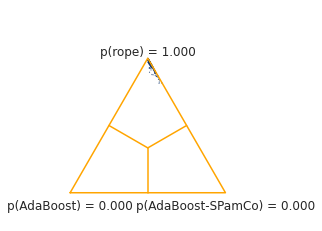

In [10]:
baycomp_ada, bayplot_ada = baycomp.two_on_multiple(
    adaboost_base_score, 
    adaboost_multi_score, 
    plot=True, 
    rope=0.05, 
    names = ('AdaBoost','AdaBoost-SPamCo'))

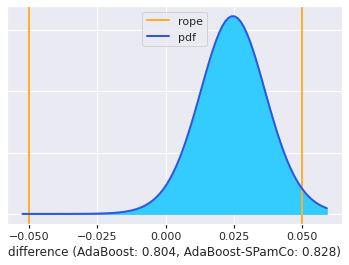

In [11]:
baycomp_ada, bayplot_ada = baycomp.two_on_single(
    np.mean(adaboost_base_score, axis=1), 
    np.mean(adaboost_multi_score, axis=1), 
    plot=True,
    rope=.05,
    names = ('AdaBoost','AdaBoost-SPamCo'))

## RandomForrestClassifier

In [12]:
rfc_base_metrics = []
rfc_base_clfs = []



model =  {
    'classifier':RandomForestClassifier(),
    'num_view':1,
    'gamma':0.3,
    'steps':5,
    'regularizer':'hard'
}

for i in label_pct:
    clfs, metrics = Validation.validation(
        model_params=model,
        train_data_x=X,
        train_data_y=y,
        percent_labeled=i,
        random_seed=seeds[0],
        iters=5
    )

    rfc_base_metrics.append(metrics)
    rfc_base_clfs.append(clfs)

rfc_base_score = np.array(rfc_base_metrics)

Validation Iteration: 0 Accuracy: 0.8364606328182487 Labels: 88
Validation Iteration: 0 Accuracy: 0.8415326395458845 Labels: 177
Validation Iteration: 0 Accuracy: 0.8429254704089141 Labels: 266
Validation Iteration: 0 Accuracy: 0.8427415116156838 Labels: 355
Validation Iteration: 0 Accuracy: 0.8410333228214023 Labels: 443
Validation Iteration: 0 Accuracy: 0.8409939030799958 Labels: 532
Validation Iteration: 0 Accuracy: 0.841414380321665 Labels: 621
Validation Iteration: 0 Accuracy: 0.8431751287711553 Labels: 710
Validation Iteration: 0 Accuracy: 0.8435824660990224 Labels: 799
Validation Iteration: 0 Accuracy: 0.8430043098917271 Labels: 887
Validation Iteration: 0 Accuracy: 0.842360454115421 Labels: 976
Validation Iteration: 0 Accuracy: 0.8434116472195943 Labels: 1065
Validation Iteration: 0 Accuracy: 0.8432408283401661 Labels: 1154
Validation Iteration: 0 Accuracy: 0.8432539682539683 Labels: 1243
Validation Iteration: 0 Accuracy: 0.844265741616735 Labels: 1331
Validation Iteration: 0 A

In [13]:
rfc_multi_metrics = []
rfc_multi_clfs = []
steps = 20
views = 2

model =  {
    'classifier':RandomForestClassifier(),
    'num_view':views,
    'gamma':0.3,
    'steps':steps,
    'regularizer':'hard',
    'update_add_num': int(X.shape[0]/steps)
}

for i in label_pct:
    clfs, metrics = Validation.validation(
        model_params=model,
        train_data_x=X,
        train_data_y=y,
        percent_labeled=i,
        random_seed=seeds[0],
        spaco=True,
        iters=5,
        hsplit=True,
        hsplit_size=views
    )

    rfc_multi_metrics.append(metrics)
    rfc_multi_clfs.append(clfs)

rfc_multi_score = np.array(rfc_multi_metrics)

Validation Iteration: 0 Accuracy: 0.8393251340271208 Labels: 88
Validation Iteration: 0 Accuracy: 0.8412304215284347 Labels: 177
Validation Iteration: 0 Accuracy: 0.8409019236833807 Labels: 266
Validation Iteration: 0 Accuracy: 0.8416114790286976 Labels: 355
Validation Iteration: 0 Accuracy: 0.841480079890676 Labels: 443
Validation Iteration: 0 Accuracy: 0.8411515820456218 Labels: 532
Validation Iteration: 0 Accuracy: 0.8407048249763481 Labels: 621
Validation Iteration: 0 Accuracy: 0.8414932198044781 Labels: 710
Validation Iteration: 0 Accuracy: 0.84132240092505 Labels: 799
Validation Iteration: 0 Accuracy: 0.8415589193734889 Labels: 887
Validation Iteration: 0 Accuracy: 0.841085882476611 Labels: 976
Validation Iteration: 0 Accuracy: 0.8412567013560391 Labels: 1065
Validation Iteration: 0 Accuracy: 0.8413618206664564 Labels: 1154
Validation Iteration: 0 Accuracy: 0.8412435614422369 Labels: 1243
Validation Iteration: 0 Accuracy: 0.8412435614422369 Labels: 1331
Validation Iteration: 0 Ac

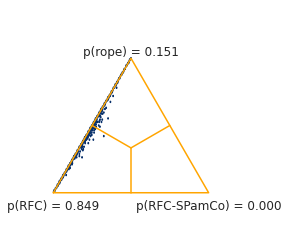

In [14]:
baycomp_rfc, bayplot_rfc = baycomp.two_on_multiple(
    rfc_base_score, 
    rfc_multi_score, 
    plot=True, 
    rope=0.001, 
    names = ('RFC','RFC-SPamCo'))

## XGBoost

In [9]:
xgboost_base_metrics = []
xgboost_base_clfs = []

model =  {
    'classifier':xgb.XGBClassifier(silent=True, verbosity=0),
    'num_view':1,
    'gamma':0.3,
    'steps':10,
    'regularizer':'hard'
}

for i in label_pct:
    clfs, metrics = Validation.validation(
        model_params=model,
        train_data_x=X,
        train_data_y=y,
        percent_labeled=i,
        random_seed=seeds[0],
        iters=5
    )

    xgboost_base_metrics.append(metrics)
    xgboost_base_clfs.append(clfs)

xgboost_base_score = np.array(xgboost_base_metrics)

Validation Iteration: 0 Accuracy: 0.8301403342794071 Labels: 88
Validation Iteration: 0 Accuracy: 0.820758435824661 Labels: 177
Validation Iteration: 0 Accuracy: 0.8184720908230843 Labels: 266
Validation Iteration: 0 Accuracy: 0.82433249237885 Labels: 355
Validation Iteration: 0 Accuracy: 0.8240828340166089 Labels: 443
Validation Iteration: 0 Accuracy: 0.8196021234100704 Labels: 532
Validation Iteration: 0 Accuracy: 0.8211132134973195 Labels: 621
Validation Iteration: 0 Accuracy: 0.8242142331546305 Labels: 710
Validation Iteration: 0 Accuracy: 0.8262115000525596 Labels: 799
Validation Iteration: 0 Accuracy: 0.8268553558288657 Labels: 887
Validation Iteration: 0 Accuracy: 0.8240696941028067 Labels: 976
Validation Iteration: 0 Accuracy: 0.8266582571218333 Labels: 1065
Validation Iteration: 0 Accuracy: 0.826474298328603 Labels: 1154
Validation Iteration: 0 Accuracy: 0.826868495742668 Labels: 1243
Validation Iteration: 0 Accuracy: 0.8251734468621886 Labels: 1331
Validation Iteration: 0 Acc

In [10]:
xgboost_multi_metrics = []
xgboost_multi_clfs = []
steps = 20
views = 2

model =  {
    'classifier':xgb.XGBClassifier(silent=True, verbosity=0),
    'num_view':views,
    'gamma':0.3,
    'steps':steps,
    'regularizer':'hard',
    'update_add_num': int(X.shape[0]/steps)
}

for i in label_pct:
    clfs, metrics = Validation.validation(
        model_params=model,
        train_data_x=X,
        train_data_y=y,
        percent_labeled=i,
        random_seed=seeds[0],
        spaco=True,
        iters=5,
        hsplit=True,
        hsplit_size=views
    )

    xgboost_multi_metrics.append(metrics)
    xgboost_multi_clfs.append(clfs)

xgboost_multi_score = np.array(xgboost_multi_metrics)

Validation Iteration: 0 Accuracy: 0.8409150635971828 Labels: 88
Validation Iteration: 0 Accuracy: 0.8424130137706297 Labels: 177
Validation Iteration: 0 Accuracy: 0.8393776936823294 Labels: 266
Validation Iteration: 0 Accuracy: 0.843161988857353 Labels: 355
Validation Iteration: 0 Accuracy: 0.8424130137706297 Labels: 443
Validation Iteration: 0 Accuracy: 0.8424130137706297 Labels: 532
Validation Iteration: 0 Accuracy: 0.8403106275622831 Labels: 621
Validation Iteration: 0 Accuracy: 0.839180594975297 Labels: 710
Validation Iteration: 0 Accuracy: 0.8424130137706297 Labels: 799
Validation Iteration: 0 Accuracy: 0.8404288867865026 Labels: 887
Validation Iteration: 0 Accuracy: 0.8433328077367812 Labels: 976
Validation Iteration: 0 Accuracy: 0.8424130137706297 Labels: 1065
Validation Iteration: 0 Accuracy: 0.8424130137706297 Labels: 1154
Validation Iteration: 0 Accuracy: 0.8424130137706297 Labels: 1243
Validation Iteration: 0 Accuracy: 0.8429911699779249 Labels: 1331
Validation Iteration: 0 

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

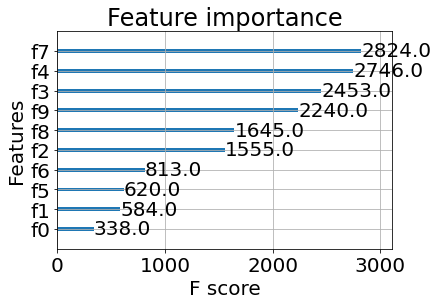

In [22]:
xgb.plot_importance(xgboost_multi_clfs[1].get_classifiers()[1]) 

In [24]:
xgboost_multi_clfs[1].get_classifiers()[1]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              silent=True, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=0)

In [25]:
xgboost_multi_clfs[0].get_classifiers()[0]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              silent=True, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=0)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

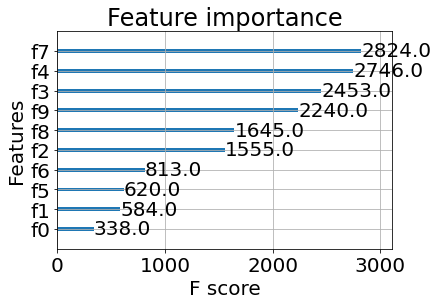

In [20]:
xgb.plot_importance(xgboost_multi_clfs[0].get_classifiers()[0])

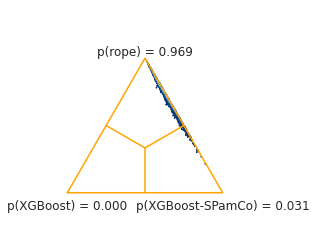

In [17]:
baycomp_xgboost, bayplot_xgboost = baycomp.two_on_multiple(
    xgboost_base_score, 
    xgboost_multi_score, 
    plot=True, 
    rope=0.02, 
    names = ('XGBoost','XGBoost-SPamCo'))

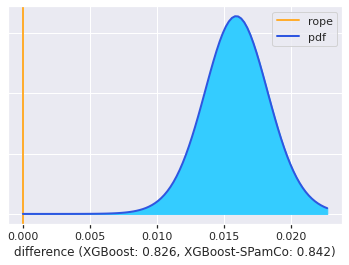

In [18]:
baycomp_xgboost, bayplot_xgboost = baycomp.two_on_single(
    np.mean(xgboost_base_score, axis=1), 
    np.mean(xgboost_multi_score, axis=1),
    
    plot=True, 
    names = ('XGBoost','XGBoost-SPamCo'))

In [19]:
baycomp_xgboost

(6.00702810049647e-07, 0.99999939929719)

In [20]:
label_pct

array([5.0e-04, 1.0e-03, 1.5e-03, 2.0e-03, 2.5e-03, 3.0e-03, 3.5e-03,
       4.0e-03, 4.5e-03, 5.0e-03, 5.5e-03, 6.0e-03, 6.5e-03, 7.0e-03,
       7.5e-03, 8.0e-03, 8.5e-03, 9.0e-03, 9.5e-03, 1.0e-02, 1.0e-01,
       5.0e-01, 9.9e-01])

In [21]:
df = pd.DataFrame()

df['Percent of Labeled Data'] = label_pct
df['AdaBoost Mean'] =  np.mean(adaboost_base_score, axis=1)
df['AdaBoost Std'] =  np.std(adaboost_base_score, axis=1)
df['AdaBoost+SPamCo Mean'] = np.mean(adaboost_multi_score, axis=1)
df['AdaBoost+SPamCo Std'] = np.std(adaboost_multi_score, axis=1)
df['RandomForest Mean'] = np.mean(rfc_base_score, axis=1)
df['RandomForest Std'] = np.std(rfc_base_score, axis=1)
df['RandomForest+SPamCo Mean'] = np.mean(rfc_multi_score, axis=1)
df['RandomForest+SPamCo Std'] = np.std(rfc_multi_score, axis=1)
df['XGBoost Mean'] = np.mean(xgboost_base_score, axis=1)
df['XGBoost Std'] = np.std(xgboost_base_score, axis=1)
df['XGBoost+SPamCo Mean'] = np.mean(xgboost_multi_score, axis=1)
df['XGBoost+SpamCo Std'] = np.std(xgboost_multi_score, axis=1)

In [22]:
df

,Percent of Labeled Data,AdaBoost Mean,AdaBoost Std,AdaBoost+SPamCo Mean,AdaBoost+SPamCo Std,RandomForest Mean,RandomForest Std,RandomForest+SPamCo Mean,RandomForest+SPamCo Std,XGBoost Mean,XGBoost Std,XGBoost+SPamCo Mean,XGBoost+SpamCo Std
0,0.0005,0.778553,0.064710,0.729623,8.541516e-02,0.837570,0.002848,0.839788,0.001393,0.818543,0.014621,0.842087,5.873056e-04
1,0.0010,0.609547,0.107354,0.632808,2.532608e-01,0.841173,0.000390,0.840757,0.000674,0.820306,0.002308,0.842416,5.255966e-06
2,0.0015,0.684043,0.098993,0.840692,2.401924e-03,0.841099,0.001808,0.840592,0.000374,0.821549,0.005093,0.841688,1.163499e-03
3,0.0020,0.741972,0.067647,0.842413,1.110223e-16,0.840539,0.001698,0.840713,0.000660,0.821665,0.004843,0.842489,3.466946e-04
4,0.0025,0.763156,0.025494,0.842413,1.110223e-16,0.841091,0.001125,0.840668,0.000425,0.822172,0.001692,0.842410,5.255966e-06
5,0.0030,0.802486,0.014272,0.842413,1.110223e-16,0.841598,0.001422,0.839932,0.000916,0.821000,0.002590,0.842245,3.363818e-04
6,0.0035,0.803979,0.015307,0.842413,1.110223e-16,0.841441,0.001377,0.840169,0.001082,0.821852,0.002178,0.841656,9.317524e-04
7,0.0040,0.812078,0.012108,0.842413,1.110223e-16,0.841924,0.000805,0.840902,0.000565,0.821076,0.002351,0.842019,1.446966e-03
8,0.0045,0.810675,0.013000,0.842408,1.051193e-05,0.842106,0.000988,0.840087,0.001352,0.822685,0.003551,0.842413,1.110223e-16
9,0.0050,0.819095,0.012658,0.842413,1.110223e-16,0.841732,0.000794,0.840799,0.000410,0.822564,0.002928,0.841979,7.785219e-04


In [23]:
df.to_csv('Multiple Classifiers on Diabetes Health Data.csv')

In [95]:
df = pd.read_csv('Multiple Classifiers on Diabetes Health Data.csv')
df =df.drop('Unnamed: 0', axis=1)
df = df[:20]
df_long =df[['Percent of Labeled Data', 'AdaBoost Mean','AdaBoost+SPamCo Mean', 'RandomForest Mean','RandomForest+SPamCo Mean', 'XGBoost Mean','XGBoost+SPamCo Mean']]
df_long.columns = ['Percent of Labeled Data', 'AdaBoost','AdaBoost+SPamCo', 'RandomForest','RandomForest+SPamCo', 'XGBoost','XGBoost+SPamCo']
df_long =pd.melt(df_long, id_vars = ['Percent of Labeled Data'], var_name='classifier', value_name = 'mean')

df_std =df[['Percent of Labeled Data', 'AdaBoost Std','AdaBoost+SPamCo Std', 'RandomForest Std','RandomForest+SPamCo Std', 'XGBoost Std','XGBoost+SpamCo Std']]
df_std.columns = ['Percent of Labeled Data', 'AdaBoost','AdaBoost+SPamCo', 'RandomForest','RandomForest+SPamCo', 'XGBoost','XGBoost+SPamCo']
df_std =pd.melt(df_std, id_vars = ['Percent of Labeled Data'], var_name='classifier', value_name = 'std')

df_long['std'] = df_std['std']

In [96]:
df_long['upper'] = df_long['mean'] + df_long['std']
df_long['lower'] = df_long['mean'] - df_long['std']

In [97]:
import plotly.express as px

fig = px.line(df_long, x="Percent of Labeled Data", y="mean", color = 'classifier')
fig.update_layout(
    yaxis_title="Mean test accuracy",
    legend_title="Classifier",
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        showgrid=True,
        zeroline=True,
        showline=True,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)'
    ),
 
    showlegend=True,
    plot_bgcolor='white'
)


fig.show()